# Signal implementation analysis: Emotional words

## Setup

In [1]:
from pathlib import Path
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# plot settings
plt.style.use('seaborn-whitegrid')

# load datasets
likert_datasets = ["credcoalition.csv", "microsoft.csv", "reconcile.csv"]
binary_datasets = ["fnn-gossip.csv", "fnn-politifact.csv"]

likert_per_file = (pd.read_csv(os.path.join(os.getcwd(), "datasets_evaluated", dataset), sep=";",index_col="url") 
                   for dataset in likert_datasets)
binary_per_file = (pd.read_csv(os.path.join(os.getcwd(), "datasets_evaluated", dataset), sep=";",index_col="url") 
                   for dataset in binary_datasets)

likert_df = pd.concat(likert_per_file)
binary_df = pd.concat(binary_per_file)

# group likert ratings into bins
likert_df["rating_bin"] = likert_df.apply(lambda row: 1 if row.rating < 1.5 else 2 if row.rating < 2.5
                                          else 3 if row.rating < 3.5 else 4 if row.rating < 4.5 else 5, axis=1)

# swap 0 <-> 1 fake news classification to facilitate comparisons with credibility ratings (higher rating = better)
binary_df["rating"] = 1 - binary_df["rating"]

# rating distributions
print("\nLikert data: " + str(likert_df.shape) + " urls x values\nRating bins distribution:")
print(likert_df["rating_bin"].value_counts().sort_index().to_string())
print("\nBinary data: " + str(binary_df.shape) + " urls x values\nRatings distribution:")
print(binary_df["rating"].value_counts().sort_index().to_string())


Likert data: (242, 84) urls x values
Rating bins distribution:
1     16
2     24
3     36
4    109
5     57

Binary data: (200, 83) urls x values
Ratings distribution:
0.0    100
1.0    100


## Total emotional words

In [2]:
signal = "total_emotion_word_ratio"

#### Scatterplots

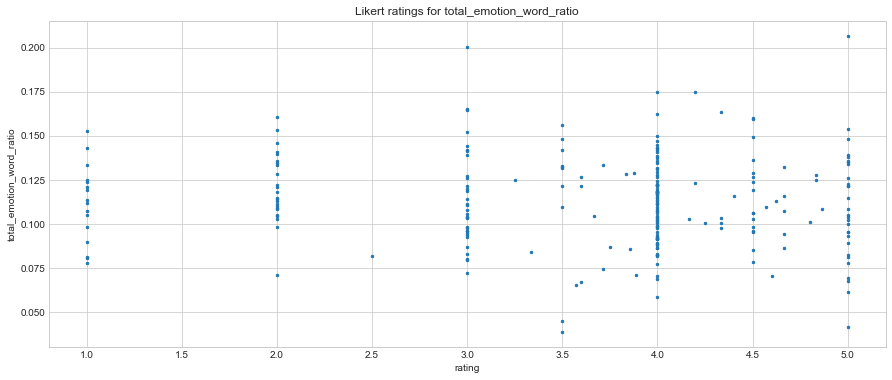

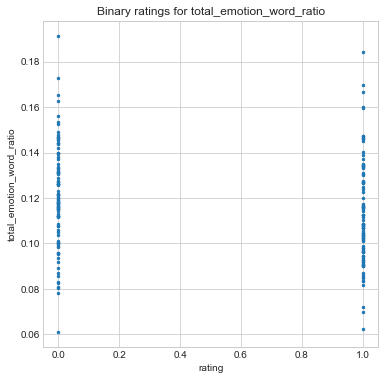

In [3]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

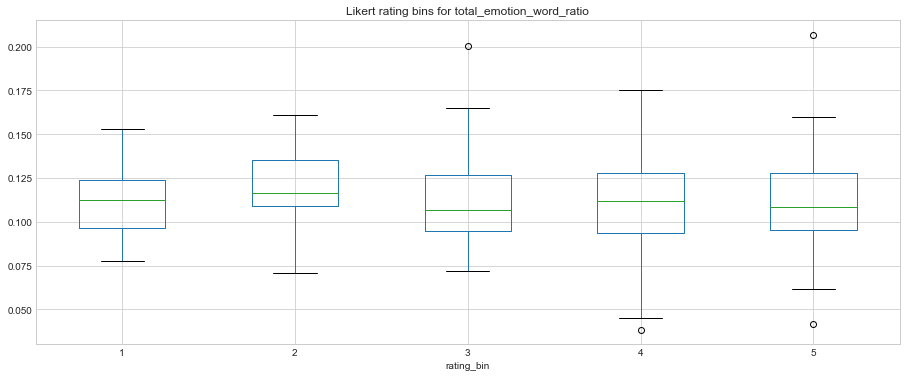

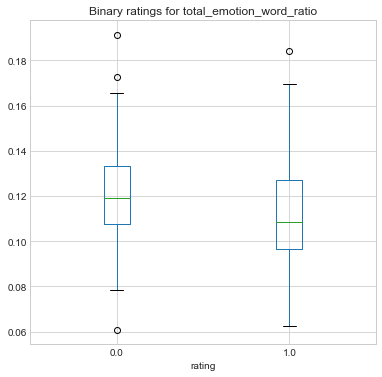

In [4]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

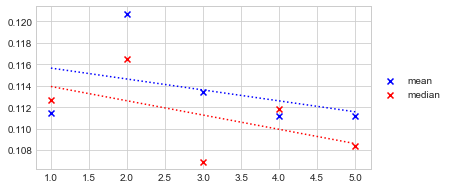

   rating      mean    median
0       1  0.111491  0.112689
1       2  0.120720  0.116530
2       3  0.113442  0.106887
3       4  0.111184  0.111782
4       5  0.111158  0.108397


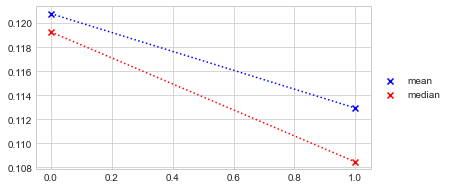

   rating      mean    median
0       0  0.120778  0.119254
1       1  0.112928  0.108449


In [5]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [6]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.06470238900103101
Likert p: 0.31616384023536964

Binary rho: -0.19979493272587112
Binary p: 0.004561499098867178


## Total emotional intensity

In [7]:
likert_df["emotion_words_intensity"] = (likert_df["anger_intensity"] + likert_df["anticipation_intensity"] 
                                        + likert_df["disgust_intensity"] + likert_df["fear_intensity"]
                                        + likert_df["sadness_intensity"] + likert_df["joy_intensity"]
                                        + likert_df["surprise_intensity"] + likert_df["trust_intensity"])
binary_df["emotion_words_intensity"] = (binary_df["anger_intensity"] + binary_df["anticipation_intensity"] 
                                        + binary_df["disgust_intensity"] + binary_df["fear_intensity"]
                                        + binary_df["sadness_intensity"] + binary_df["joy_intensity"]
                                        + binary_df["surprise_intensity"] + binary_df["trust_intensity"])

signal = "emotion_words_intensity"

#### Scatterplots

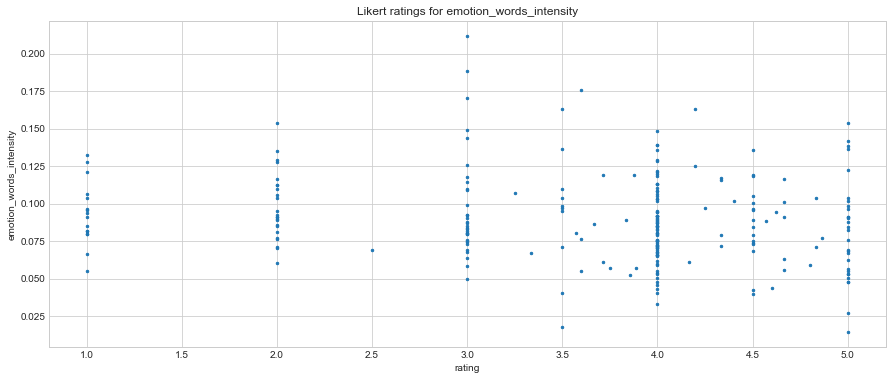

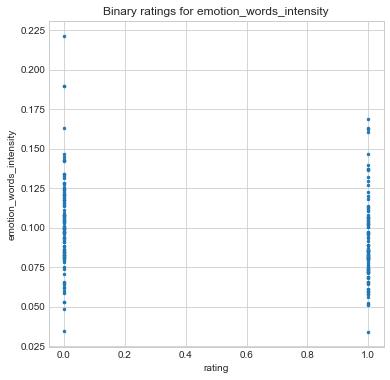

In [8]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

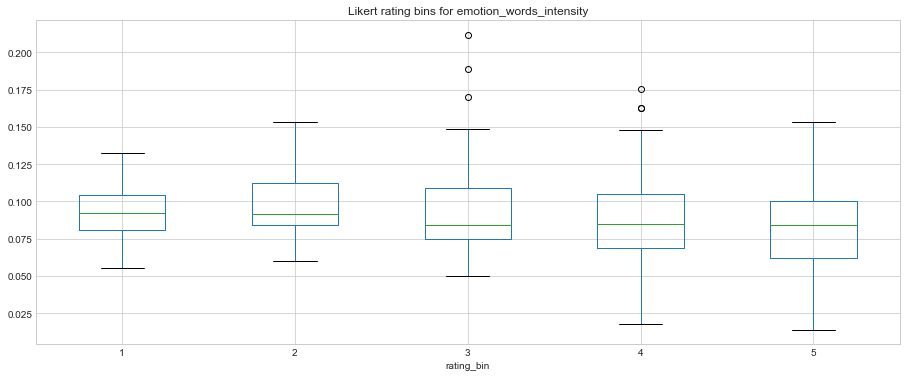

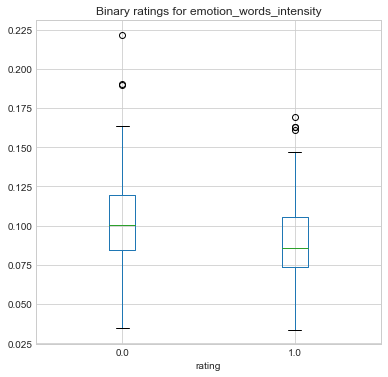

In [9]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

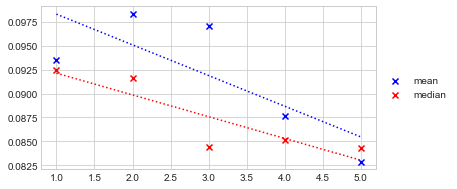

   rating      mean    median
0       1  0.093527  0.092484
1       2  0.098342  0.091582
2       3  0.097031  0.084366
3       4  0.087637  0.085150
4       5  0.082863  0.084341


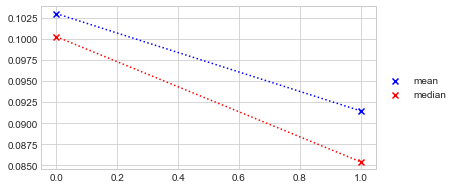

   rating      mean    median
0       0  0.102999  0.100258
1       1  0.091441  0.085381


In [10]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [11]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1559482756643348
Likert p: 0.01516977782185942

Binary rho: -0.23071205148684265
Binary p: 0.0010134546416450394


## Combined top 5 emotion intensities

In [12]:
# combined emotion intensities without trust, joy, anticipation
likert_df["combined_intensity_top5"] = (likert_df["anger_intensity"] + likert_df["disgust_intensity"]
                                        + likert_df["fear_intensity"] + likert_df["sadness_intensity"]
                                        + likert_df["surprise_intensity"])
binary_df["combined_intensity_top5"] = (binary_df["anger_intensity"] + binary_df["disgust_intensity"]
                                        + binary_df["fear_intensity"] + binary_df["sadness_intensity"]
                                        + binary_df["surprise_intensity"])

signal = "combined_intensity_top5"

#### Scatterplots

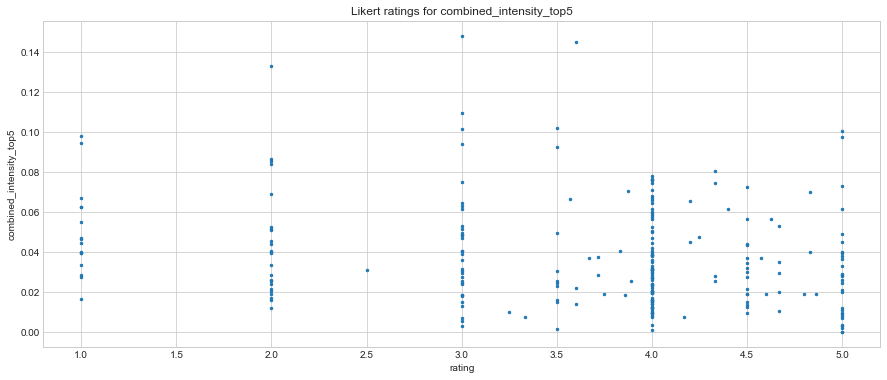

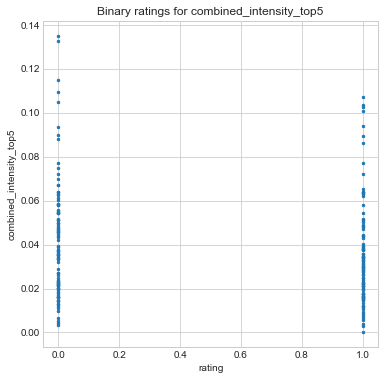

In [13]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

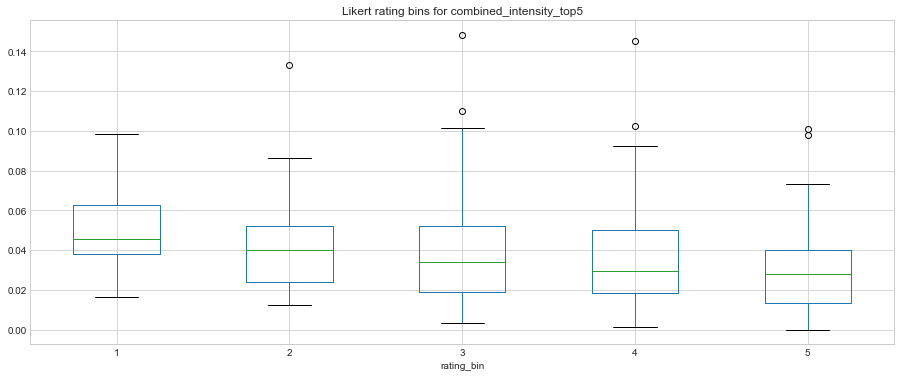

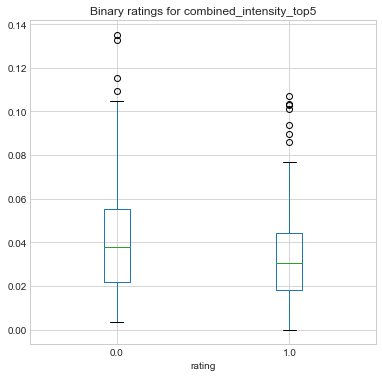

In [14]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

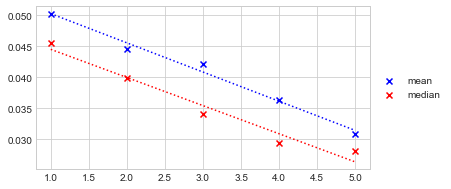

   rating      mean    median
0       1  0.050245  0.045581
1       2  0.044610  0.039931
2       3  0.042180  0.034059
3       4  0.036271  0.029479
4       5  0.030933  0.028168


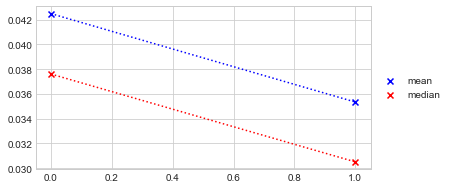

   rating      mean    median
0       0  0.042496  0.037610
1       1  0.035343  0.030503


In [15]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [16]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.20149871984431586
Likert p: 0.001628604426414375

Binary rho: -0.14791898796528802
Binary p: 0.03659167786231222


## Combined top 3 emotion intensities

In [17]:
# combined emotion intensities for anger, disgust and fear
likert_df["combined_intensity_top3"] = (likert_df["anger_intensity"] + likert_df["disgust_intensity"]
                                        + likert_df["fear_intensity"])
binary_df["combined_intensity_top3"] = (binary_df["anger_intensity"] + binary_df["disgust_intensity"]
                                        + binary_df["fear_intensity"])

signal = "combined_intensity_top3"

#### Scatterplots

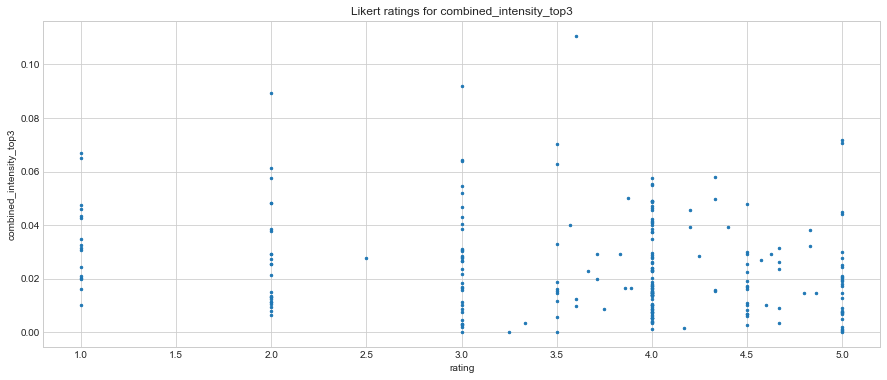

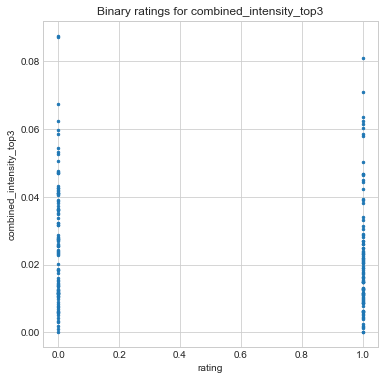

In [18]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

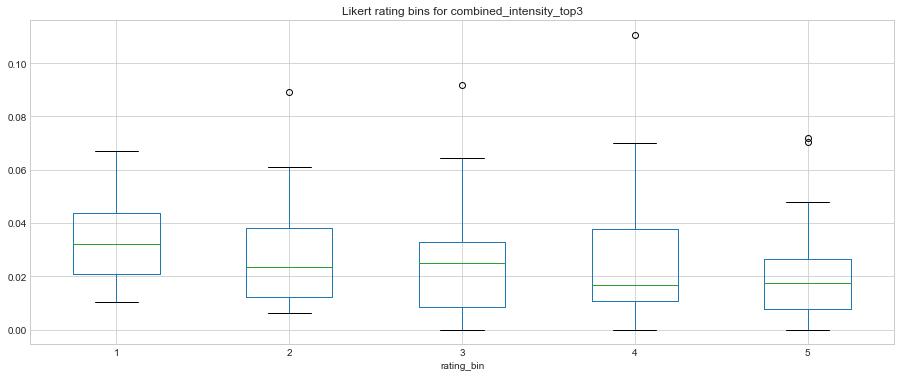

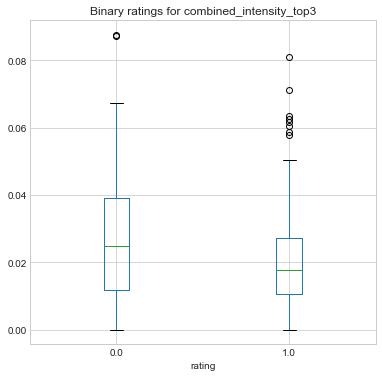

In [19]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

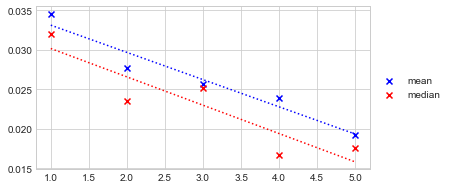

   rating      mean    median
0       1  0.034547  0.031996
1       2  0.027709  0.023504
2       3  0.025627  0.025167
3       4  0.023892  0.016668
4       5  0.019243  0.017492


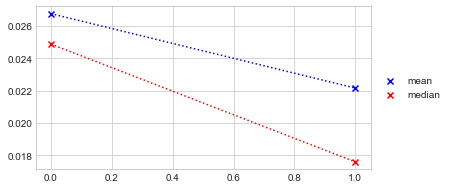

   rating      mean    median
0       0  0.026751  0.024871
1       1  0.022151  0.017592


In [20]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [21]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.18290473089179637
Likert p: 0.004307492301385049

Binary rho: -0.14185694715105335
Binary p: 0.045098991066112586


## Anger words

In [22]:
signal = "anger_word_ratio"

#### Scatterplots

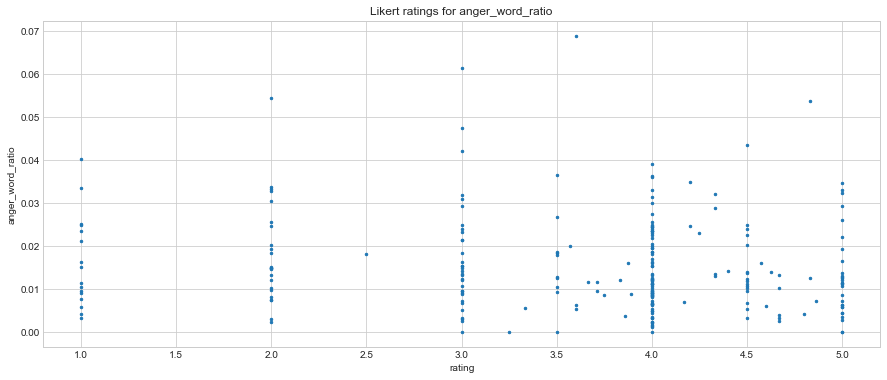

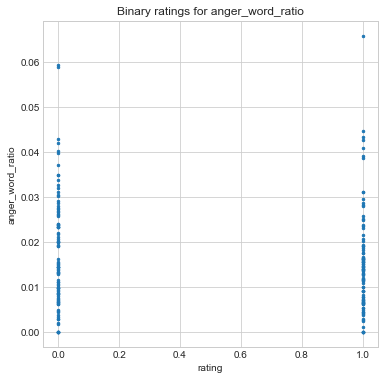

In [23]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

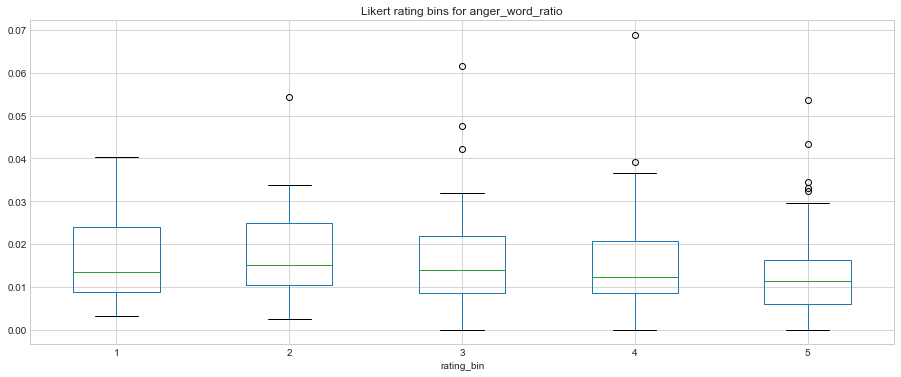

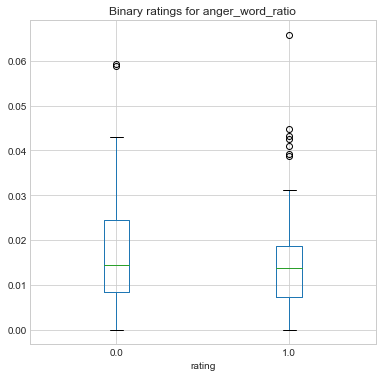

In [24]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

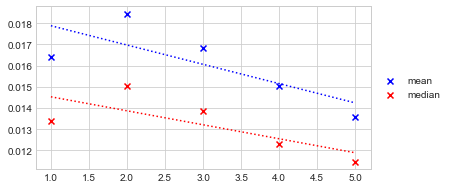

   rating      mean    median
0       1  0.016415  0.013379
1       2  0.018451  0.015029
2       3  0.016812  0.013874
3       4  0.015048  0.012278
4       5  0.013561  0.011450


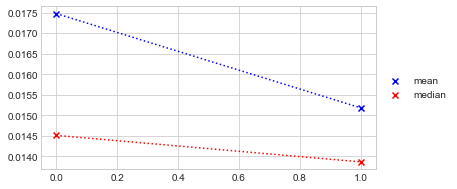

   rating      mean    median
0       0  0.017473  0.014504
1       1  0.015175  0.013859


In [25]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [26]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.11856955518520101
Likert p: 0.06555411893470836

Binary rho: -0.09423262247797991
Binary p: 0.18442509313813094


## Anger intensity

In [27]:
signal = "anger_intensity"

#### Scatterplots

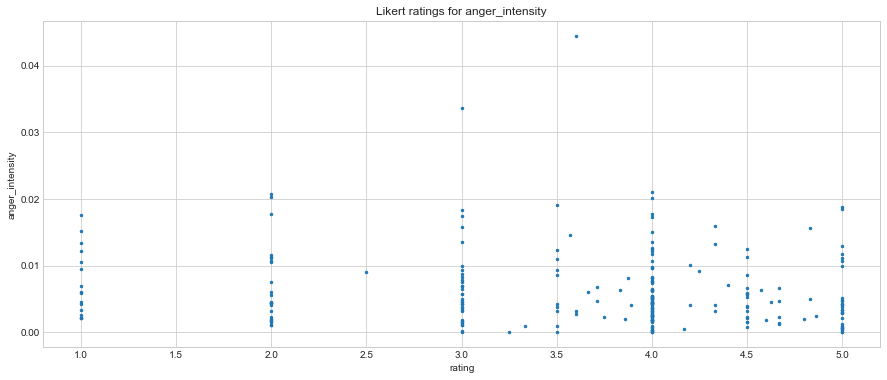

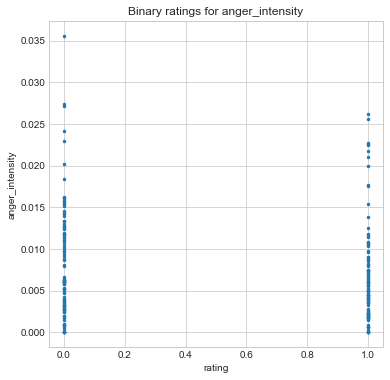

In [28]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

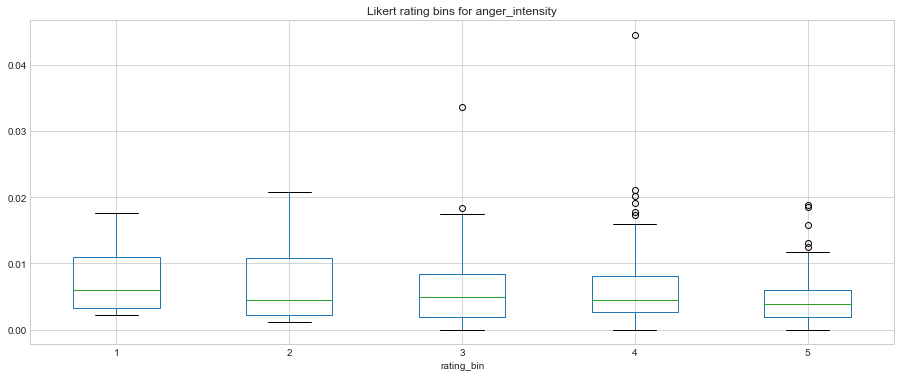

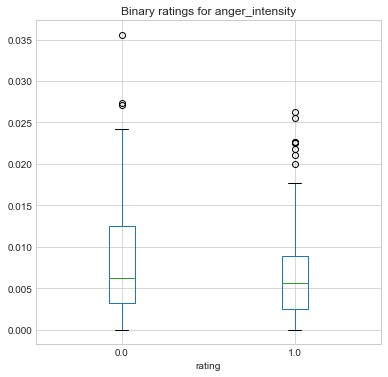

In [29]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

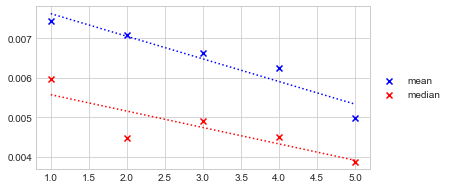

   rating      mean    median
0       1  0.007433  0.005963
1       2  0.007088  0.004466
2       3  0.006634  0.004913
3       4  0.006251  0.004495
4       5  0.004986  0.003872


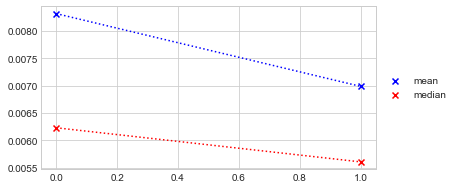

   rating      mean    median
0       0  0.008314  0.006230
1       1  0.006985  0.005607


In [30]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [31]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1461652546601118
Likert p: 0.022950800081830345

Binary rho: -0.10635802407700255
Binary p: 0.1338849047108995


## Anticipation words

In [32]:
signal = "anticipation_word_ratio"

#### Scatterplots

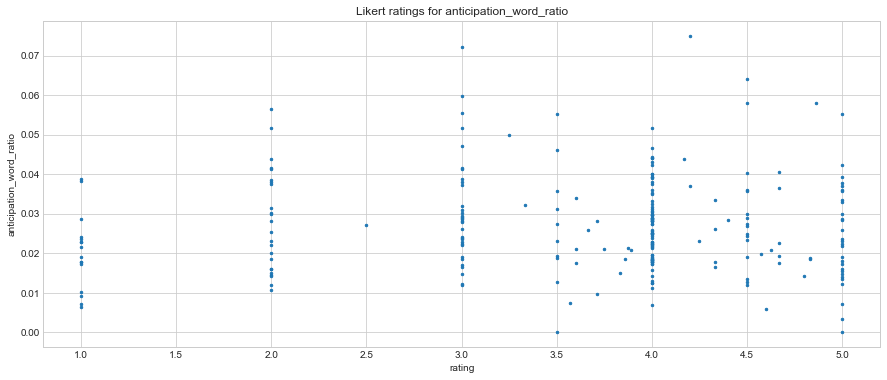

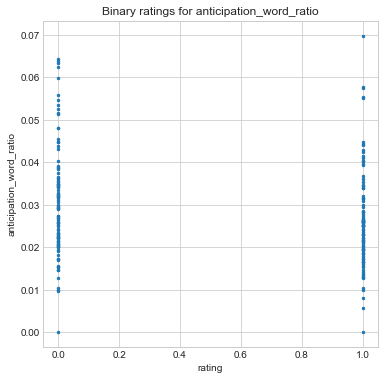

In [33]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

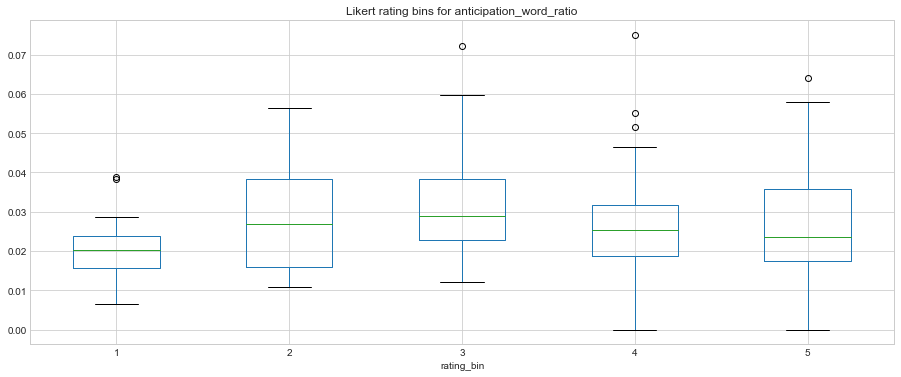

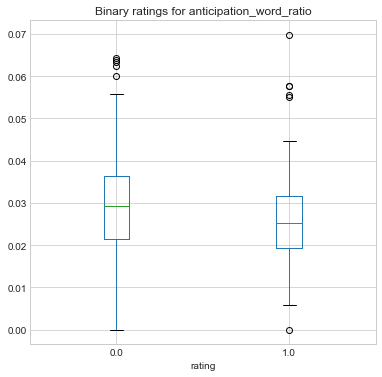

In [34]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

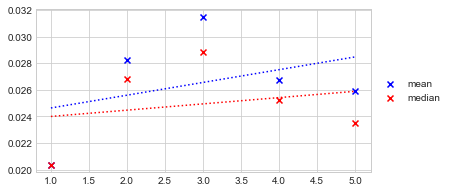

   rating      mean    median
0       1  0.020374  0.020348
1       2  0.028216  0.026779
2       3  0.031498  0.028831
3       4  0.026757  0.025253
4       5  0.025906  0.023474


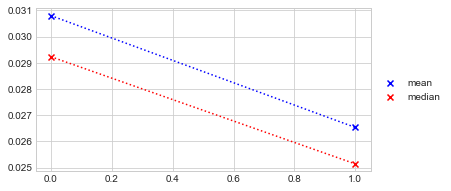

   rating      mean    median
0       0  0.030800  0.029232
1       1  0.026535  0.025144


In [35]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [36]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.007830615786280536
Likert p: 0.9035429708630054

Binary rho: -0.17545920325276804
Binary p: 0.01295063288993541


## Anticipation intensity

In [37]:
signal = "anticipation_intensity"

#### Scatterplots

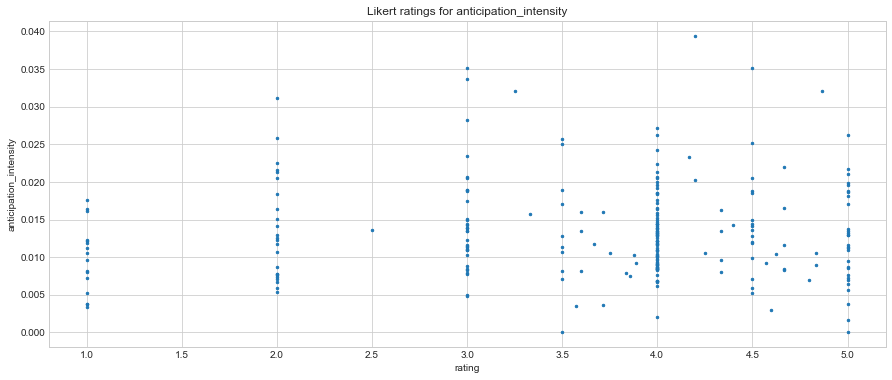

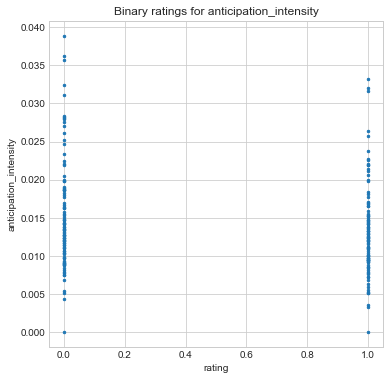

In [38]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

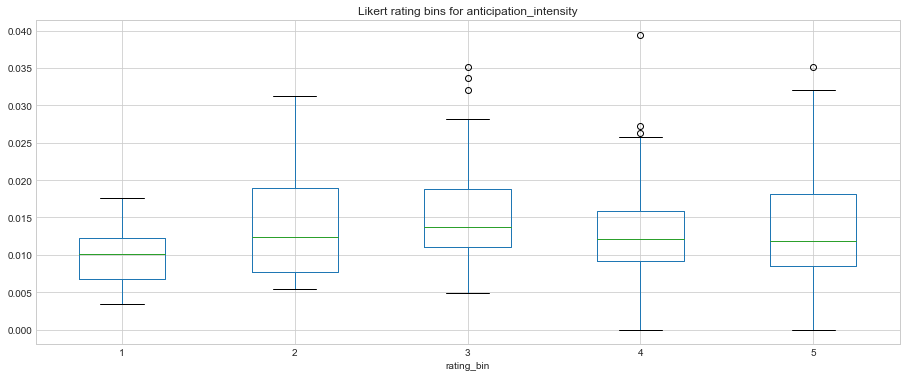

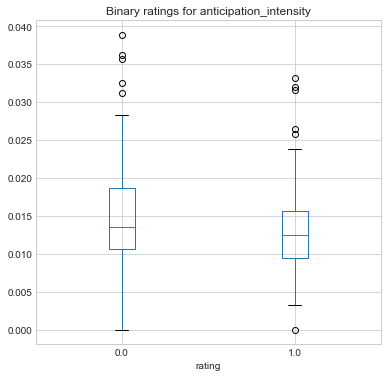

In [39]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

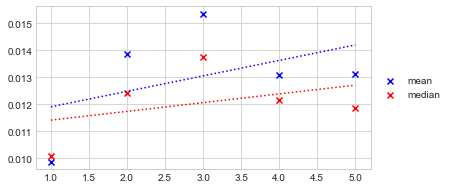

   rating      mean    median
0       1  0.009859  0.010094
1       2  0.013837  0.012425
2       3  0.015349  0.013742
3       4  0.013070  0.012161
4       5  0.013105  0.011845


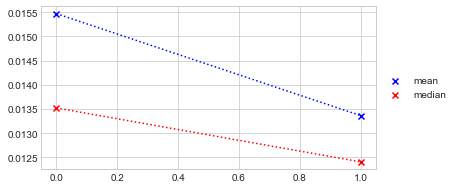

   rating      mean    median
0       0  0.015470  0.013519
1       1  0.013361  0.012404


In [40]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [41]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.023851215080891875
Likert p: 0.712001559860935

Binary rho: -0.13969169617259636
Binary p: 0.048513801502219664


## Disgust words

In [42]:
signal = "disgust_word_ratio"

#### Scatterplots

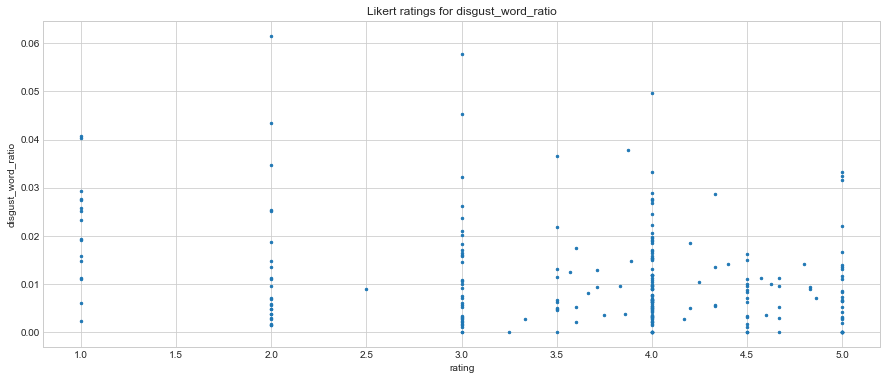

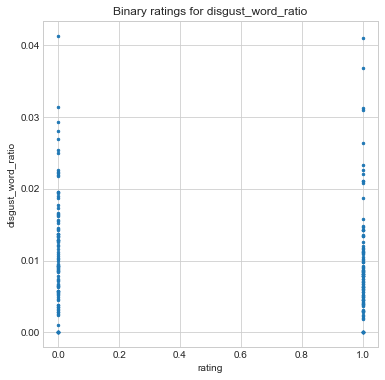

In [43]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

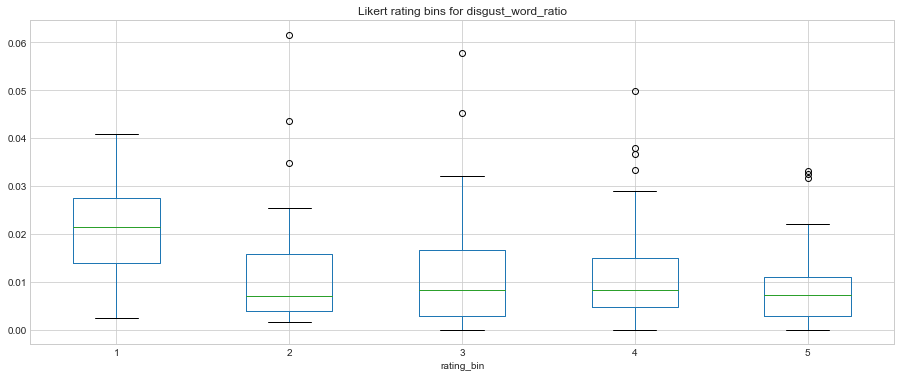

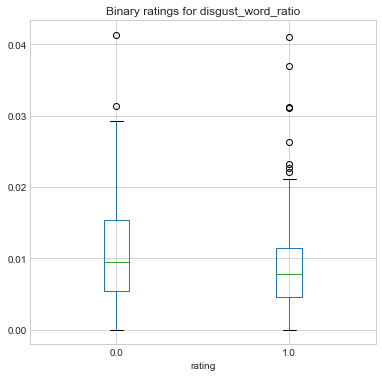

In [44]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

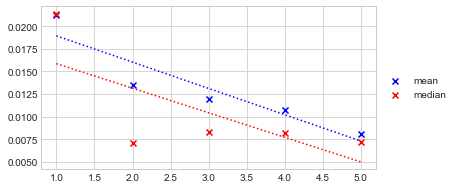

   rating      mean    median
0       1  0.021255  0.021368
1       2  0.013460  0.007042
2       3  0.011988  0.008285
3       4  0.010762  0.008165
4       5  0.008088  0.007246


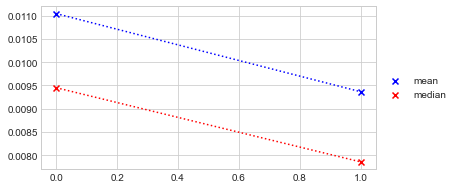

   rating      mean    median
0       0  0.011047  0.009450
1       1  0.009364  0.007852


In [45]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [46]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1918301558263818
Likert p: 0.0027300385083003156

Binary rho: -0.13791569477836546
Binary p: 0.05147317757029332


## Disgust intensity

In [47]:
signal = "disgust_intensity"

#### Scatterplots

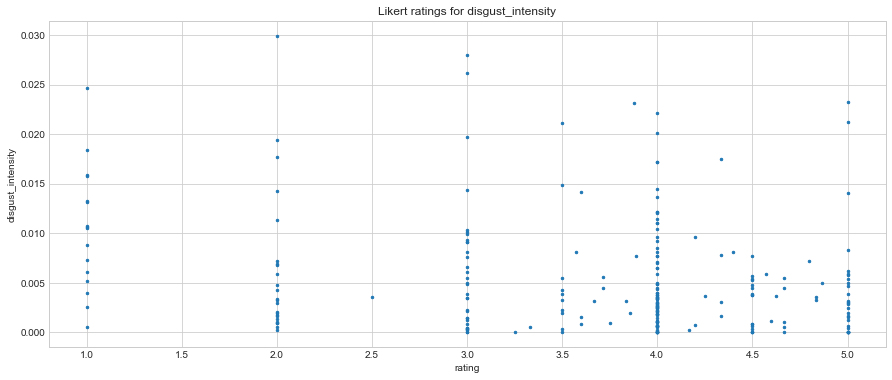

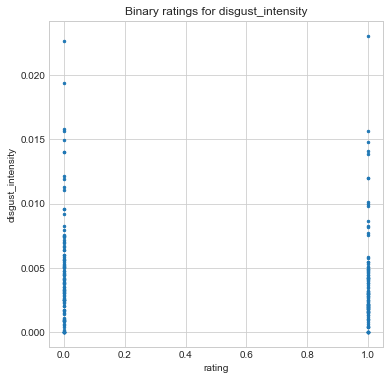

In [48]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

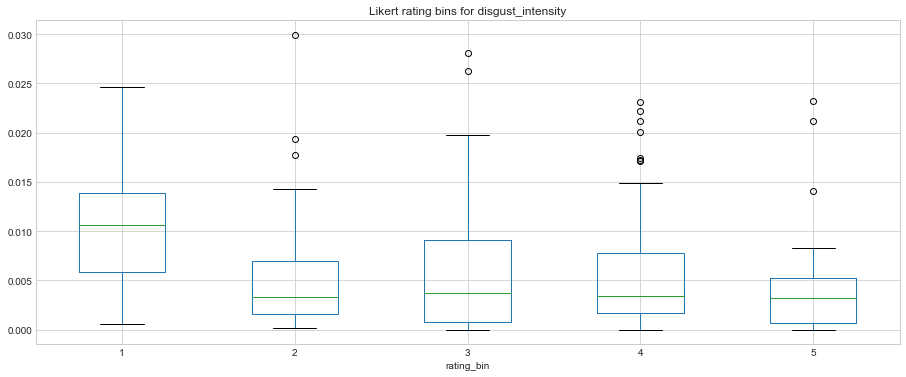

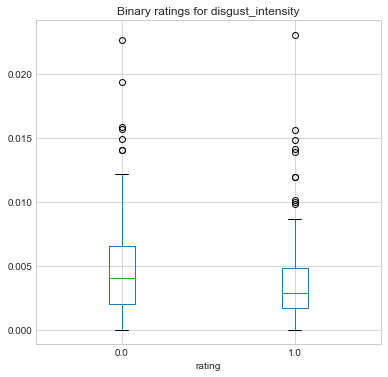

In [49]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

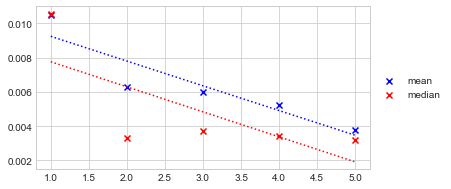

   rating      mean    median
0       1  0.010471  0.010570
1       2  0.006282  0.003297
2       3  0.006009  0.003697
3       4  0.005244  0.003401
4       5  0.003766  0.003206


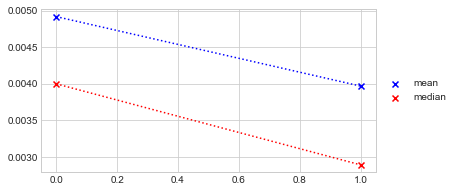

   rating      mean    median
0       0  0.004917  0.004000
1       1  0.003969  0.002894


In [50]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [51]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.204032110544014
Likert p: 0.001416846983432553

Binary rho: -0.13687561562621553
Binary p: 0.05327484901149462


## Fear words

In [52]:
signal = "fear_word_ratio"

#### Scatterplots

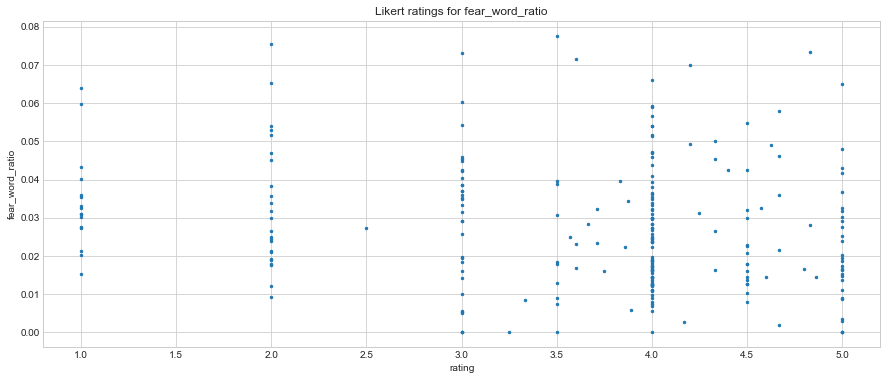

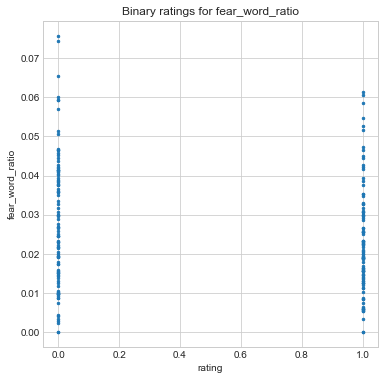

In [53]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

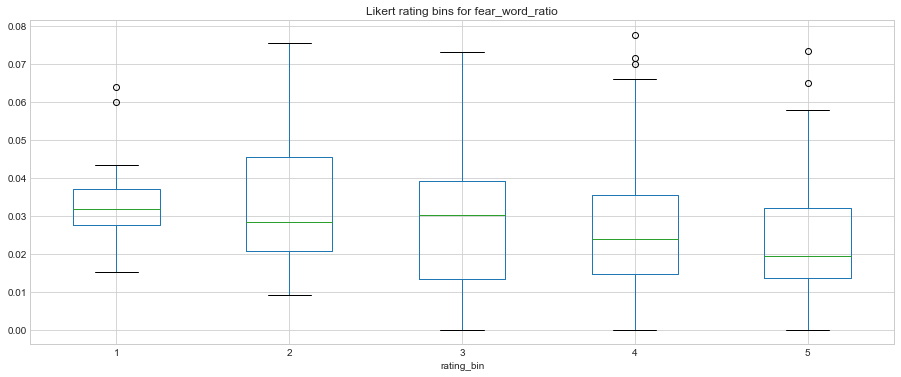

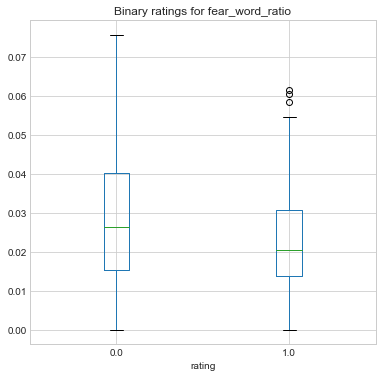

In [54]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

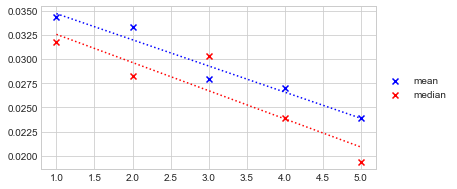

   rating      mean    median
0       1  0.034298  0.031738
1       2  0.033263  0.028289
2       3  0.027928  0.030294
3       4  0.026974  0.023932
4       5  0.023929  0.019366


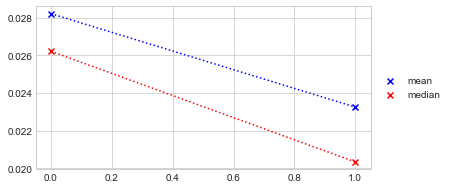

   rating      mean    median
0       0  0.028222  0.026218
1       1  0.023247  0.020329


In [55]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [56]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1779803507101651
Likert p: 0.005493208414144709

Binary rho: -0.15138404121218837
Binary p: 0.03236913821968729


## Fear intensity

In [57]:
signal = "fear_intensity"

#### Scatterplots

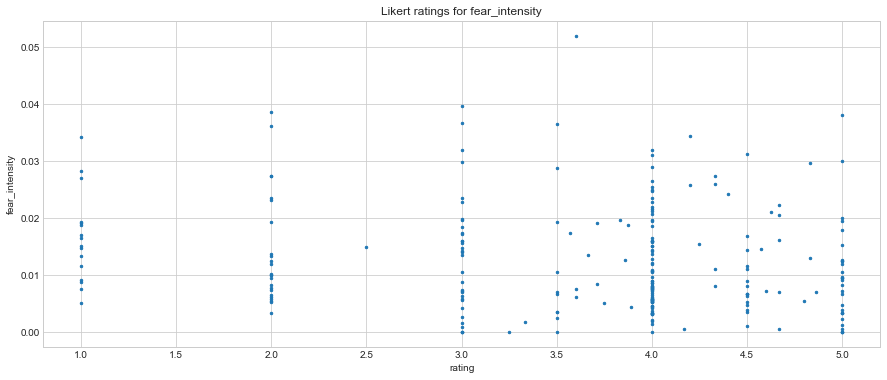

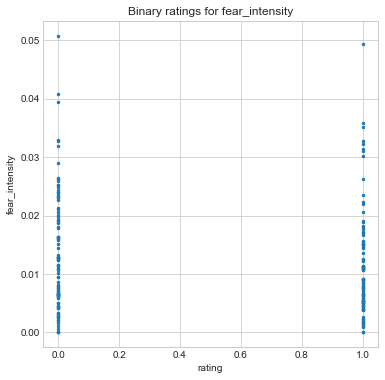

In [58]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

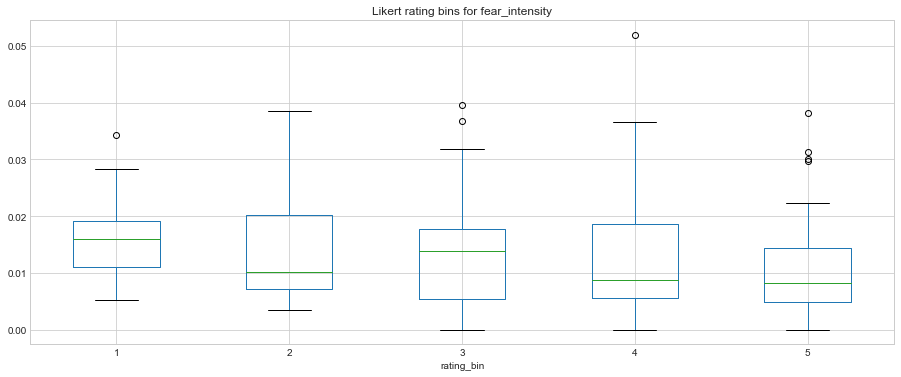

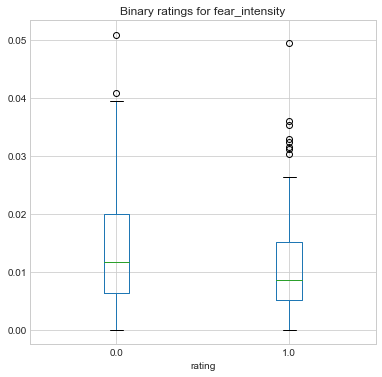

In [59]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

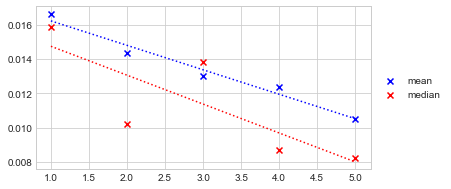

   rating      mean    median
0       1  0.016643  0.015887
1       2  0.014339  0.010219
2       3  0.012984  0.013841
3       4  0.012397  0.008693
4       5  0.010491  0.008232


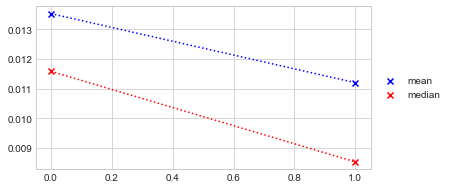

   rating      mean    median
0       0  0.013520  0.011579
1       1  0.011197  0.008530


In [60]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [61]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.15072205132675104
Likert p: 0.018978021643936336

Binary rho: -0.13302366367338805
Binary p: 0.06040841564671751


## Sadness words

In [62]:
signal = "sadness_word_ratio"

#### Scatterplots

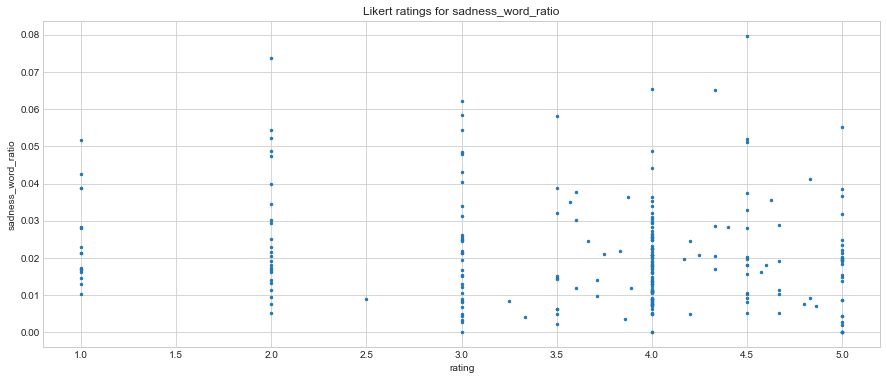

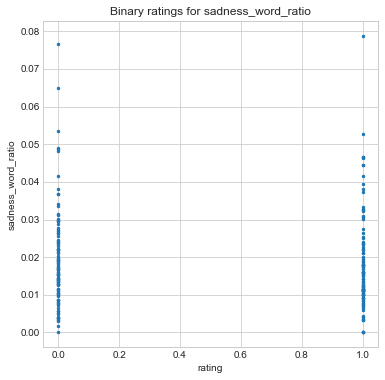

In [63]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

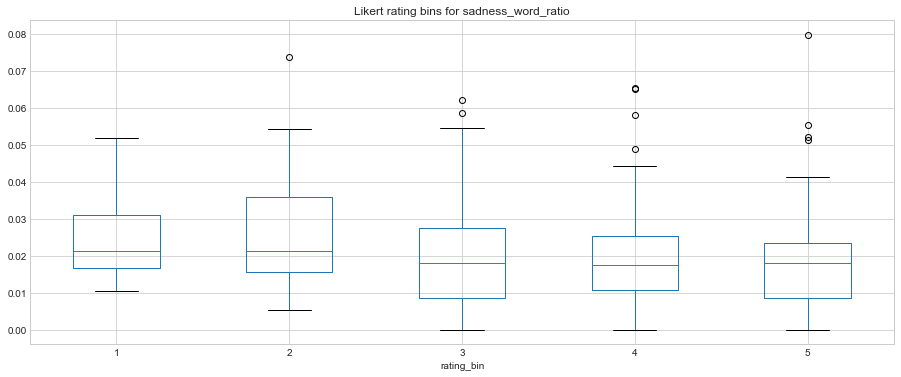

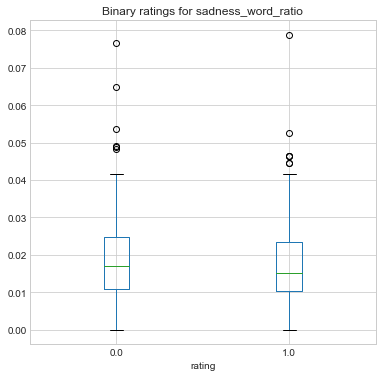

In [64]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

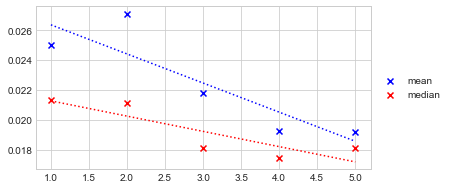

   rating      mean    median
0       1  0.024985  0.021352
1       2  0.027100  0.021149
2       3  0.021782  0.018116
3       4  0.019265  0.017425
4       5  0.019176  0.018116


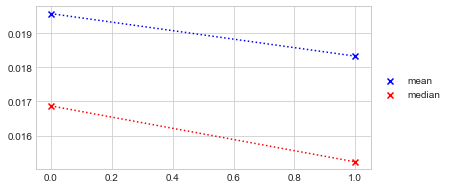

   rating      mean    median
0       0  0.019569  0.016868
1       1  0.018324  0.015229


In [65]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [66]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.14988803057972833
Likert p: 0.019656968067080106

Binary rho: -0.06772459187580465
Binary p: 0.34066023409034685


## Sadness intensity

In [67]:
signal = "sadness_intensity"

#### Scatterplots

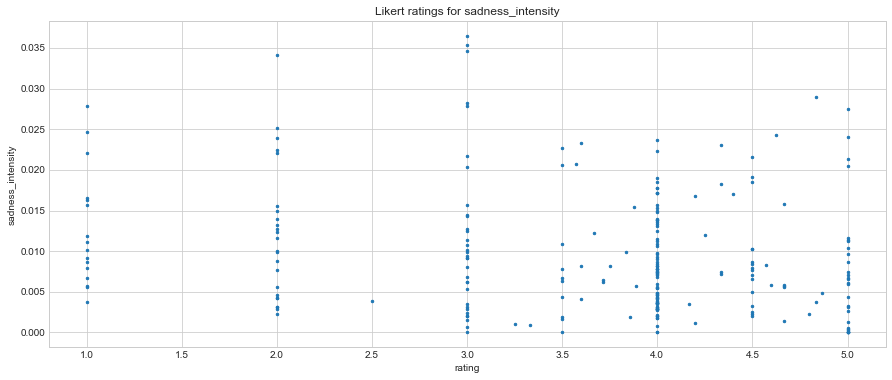

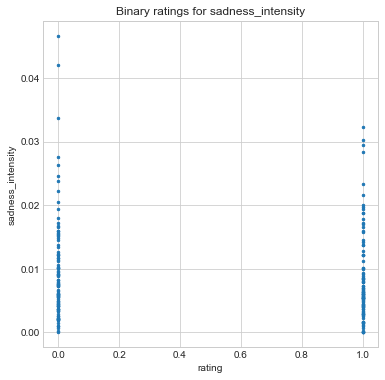

In [68]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

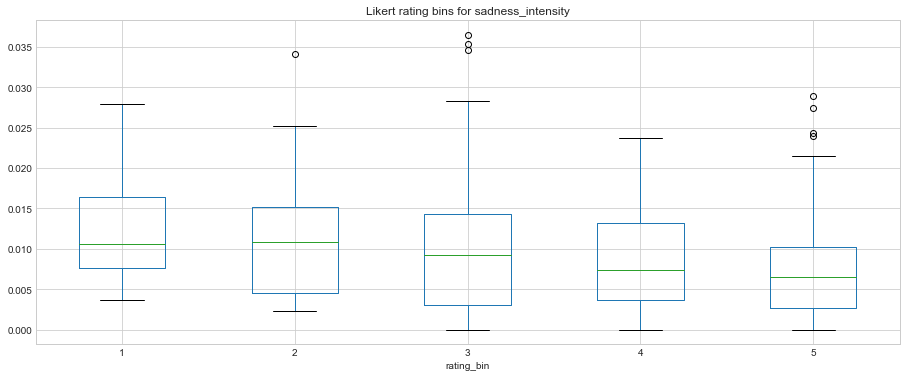

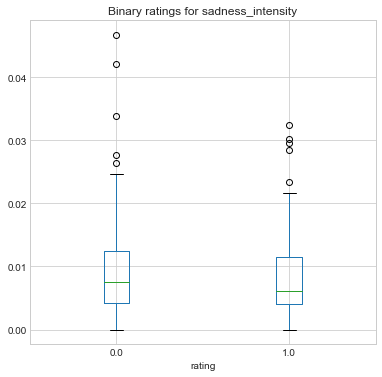

In [69]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

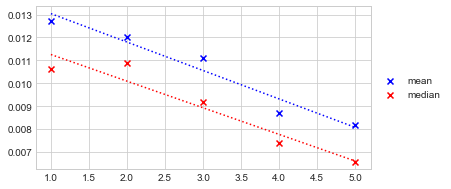

   rating      mean    median
0       1  0.012730  0.010638
1       2  0.012035  0.010868
2       3  0.011120  0.009177
3       4  0.008713  0.007378
4       5  0.008171  0.006558


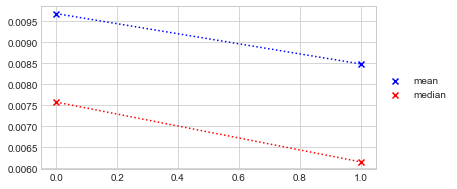

   rating      mean    median
0       0  0.009676  0.007572
1       1  0.008480  0.006151


In [70]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [71]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.1860485777799481
Likert p: 0.0036765895823786055

Binary rho: -0.07759742814316836
Binary p: 0.27476168607573964


## Joy words

In [72]:
signal = "joy_word_ratio"

#### Scatterplots

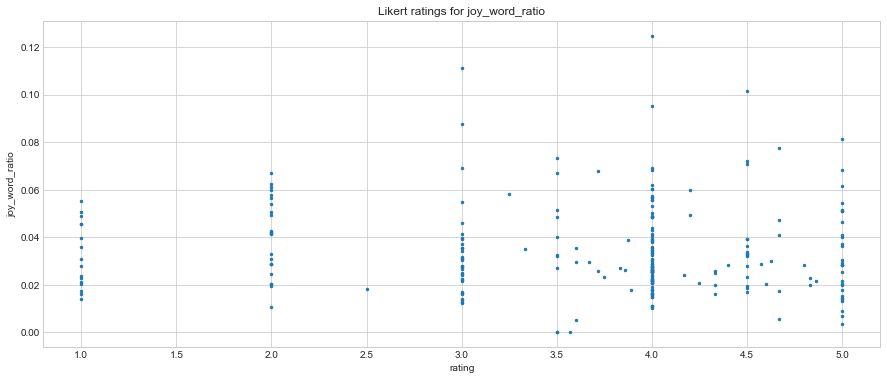

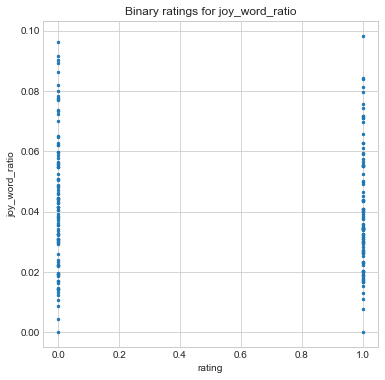

In [73]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

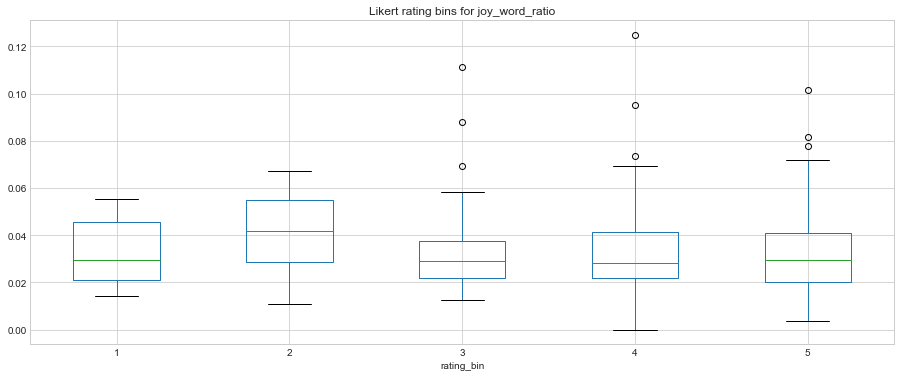

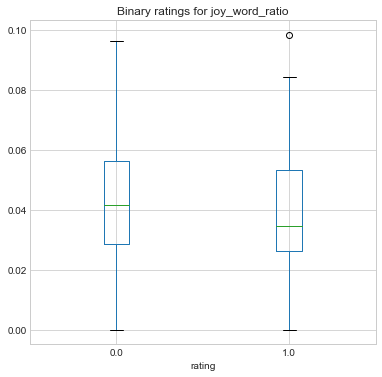

In [74]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

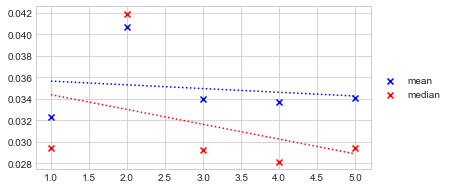

   rating      mean    median
0       1  0.032310  0.029408
1       2  0.040661  0.041897
2       3  0.033922  0.029227
3       4  0.033725  0.028118
4       5  0.034046  0.029412


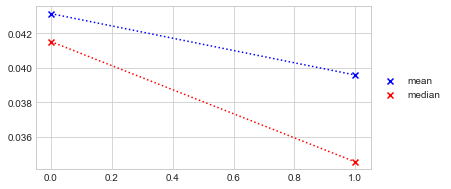

   rating      mean    median
0       0  0.043150  0.041527
1       1  0.039583  0.034542


In [75]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [76]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.0716984548301765
Likert p: 0.26655898490081104

Binary rho: -0.08599746206971624
Binary p: 0.22596858451516502


## Joy intensity

In [77]:
signal = "joy_intensity"

#### Scatterplots

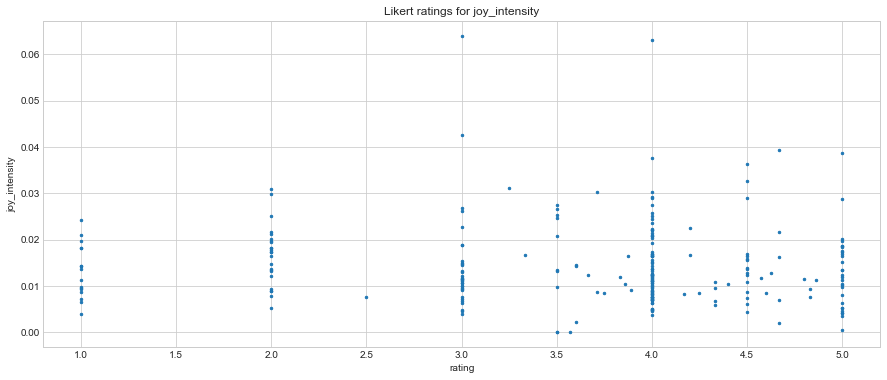

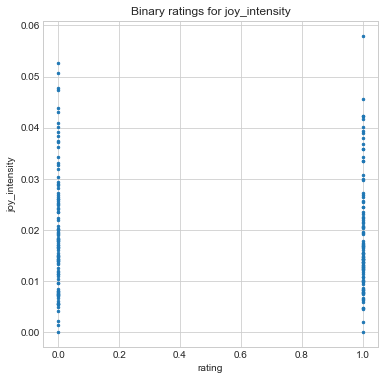

In [78]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

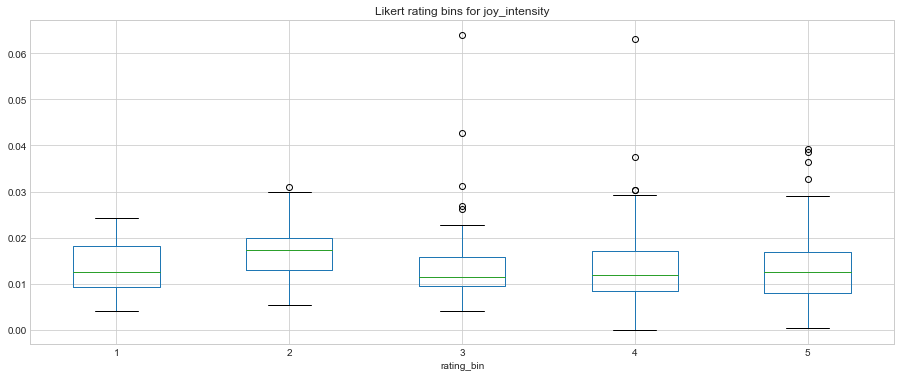

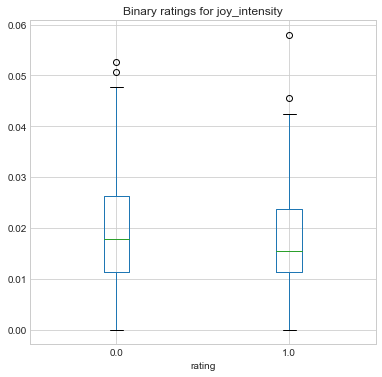

In [79]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

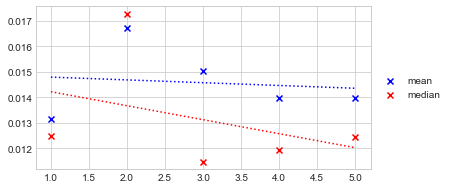

   rating      mean    median
0       1  0.013138  0.012493
1       2  0.016729  0.017290
2       3  0.015053  0.011459
3       4  0.013988  0.011924
4       5  0.013960  0.012423


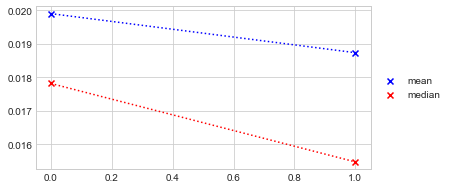

   rating      mean    median
0       0  0.019903  0.017819
1       1  0.018738  0.015480


In [80]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [81]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.08426318808089261
Likert p: 0.19142841568744662

Binary rho: -0.05360766269735719
Binary p: 0.4508989526807088


## Surprise words

In [82]:
signal = "surprise_word_ratio"

#### Scatterplots

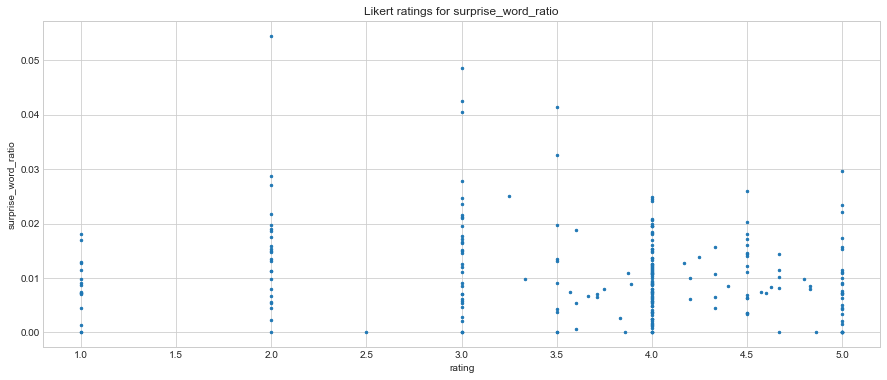

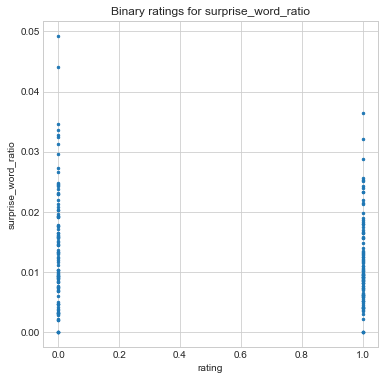

In [83]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

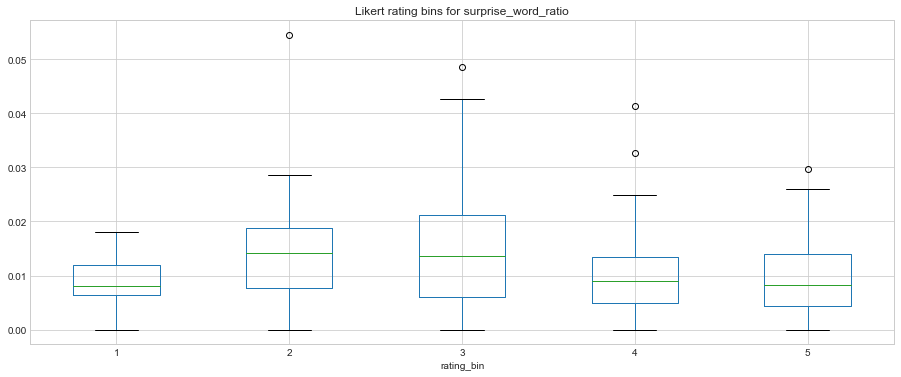

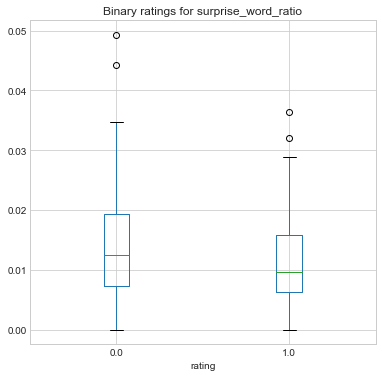

In [84]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

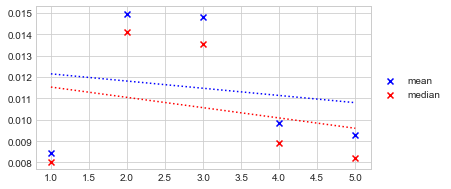

   rating      mean    median
0       1  0.008427  0.008027
1       2  0.014965  0.014122
2       3  0.014816  0.013539
3       4  0.009863  0.008913
4       5  0.009292  0.008222


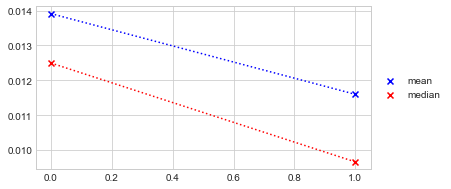

   rating      mean    median
0       0  0.013913  0.012495
1       1  0.011596  0.009656


In [85]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [86]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.13739291864161127
Likert p: 0.03264619856188938

Binary rho: -0.10618113865719746
Binary p: 0.13453658189849202


## Surprise intensity

In [87]:
signal = "surprise_intensity"

#### Scatterplots

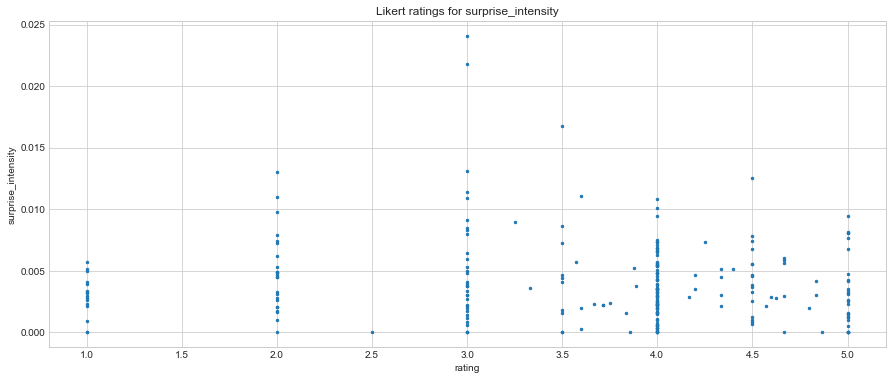

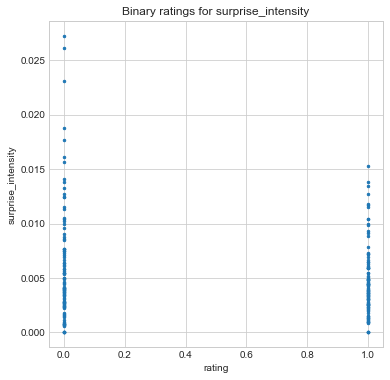

In [88]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

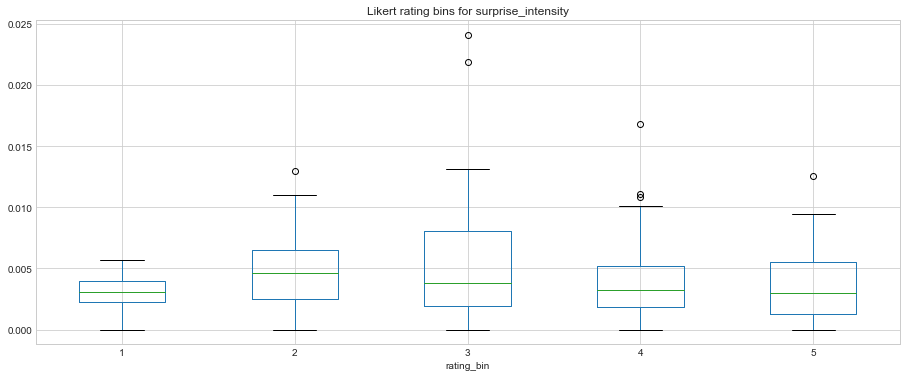

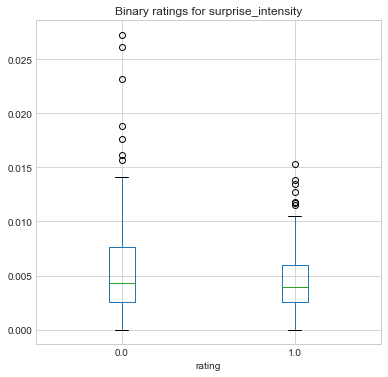

In [89]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

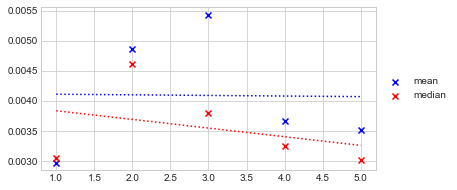

   rating      mean    median
0       1  0.002969  0.003056
1       2  0.004866  0.004621
2       3  0.005434  0.003792
3       4  0.003666  0.003244
4       5  0.003519  0.003025


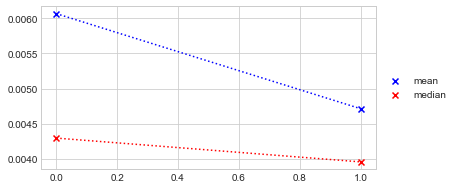

   rating      mean    median
0       0  0.006069  0.004293
1       1  0.004712  0.003954


In [90]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [91]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: -0.08656785005050287
Likert p: 0.17952202459133798

Binary rho: -0.08574144524951074
Binary p: 0.22735855316791945


## Trust words

In [92]:
signal = "trust_word_ratio"

#### Scatterplots

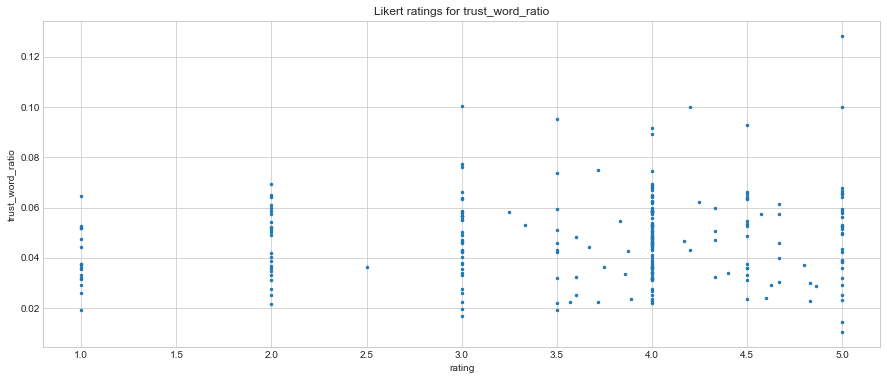

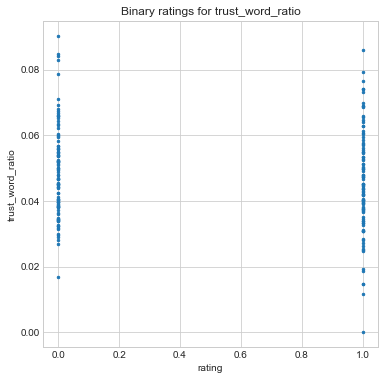

In [93]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

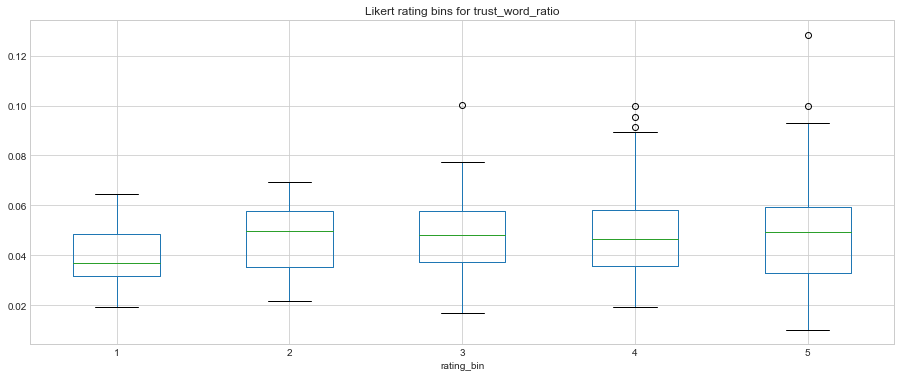

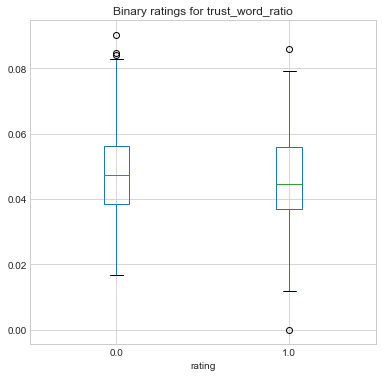

In [94]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

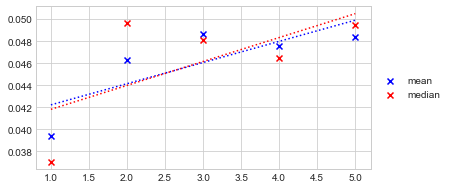

   rating      mean    median
0       1  0.039422  0.037030
1       2  0.046291  0.049642
2       3  0.048593  0.048124
3       4  0.047536  0.046433
4       5  0.048407  0.049492


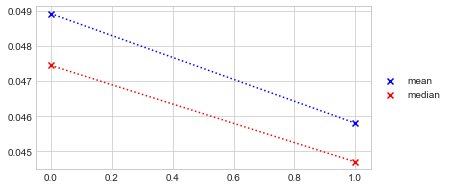

   rating      mean    median
0       0  0.048919  0.047443
1       1  0.045799  0.044694


In [95]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [96]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.08294293118425106
Likert p: 0.19850404805000108

Binary rho: -0.08729645191394046
Binary p: 0.21900883826010267


## Trust intensity

In [97]:
signal = "trust_intensity"

#### Scatterplots

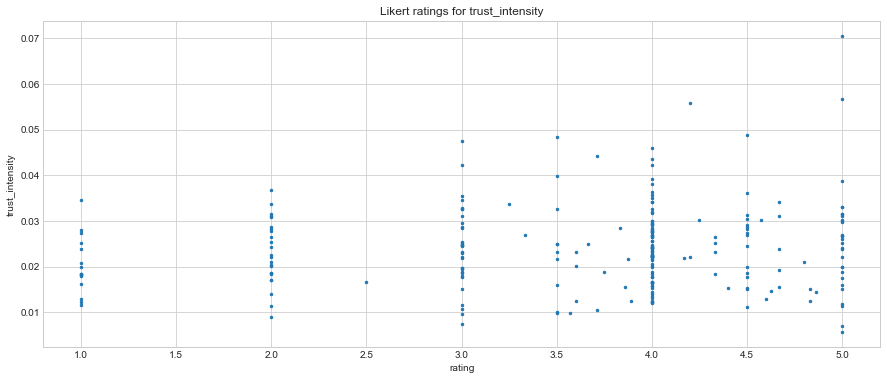

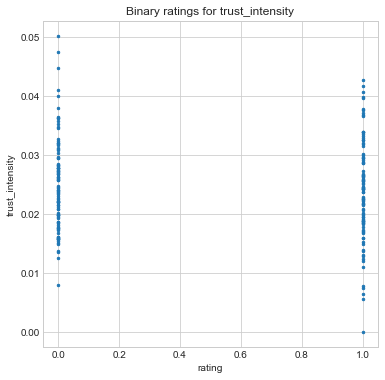

In [98]:
likert_df.plot.scatter("rating", signal, s=6, figsize=(15, 6), title="Likert ratings for " + signal)
plt.show()
binary_df.plot.scatter("rating", signal, s=6, figsize=(6, 6), title="Binary ratings for " + signal)
plt.show()

#### Boxplots

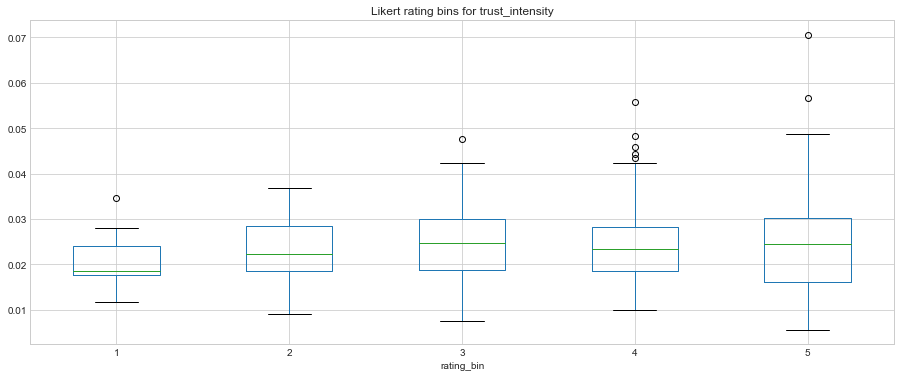

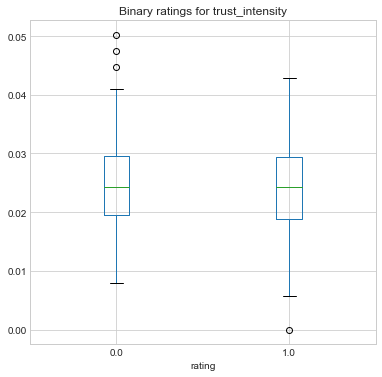

In [99]:
likert_df.boxplot(by="rating_bin", column=signal, figsize=(15, 6)).set_title("Likert rating bins for " + signal)
plt.suptitle("")
plt.show()
binary_df.boxplot(by="rating", column=signal, figsize=(6, 6)).set_title("Binary ratings for " + signal)
plt.suptitle("")
plt.show()

#### Mean & median

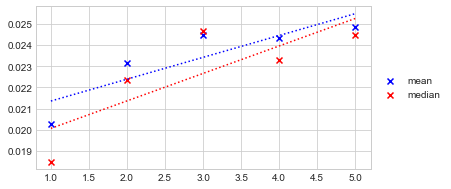

   rating      mean    median
0       1  0.020285  0.018484
1       2  0.023165  0.022343
2       3  0.024449  0.024668
3       4  0.024308  0.023306
4       5  0.024865  0.024479


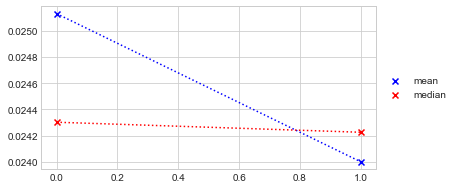

   rating      mean    median
0       0  0.025131  0.024302
1       1  0.023999  0.024225


In [100]:
likert_means = [likert_df[likert_df.rating_bin == rating][signal].mean() for rating in [1, 2, 3, 4, 5]]
likert_medians = [likert_df[likert_df.rating_bin == rating][signal].median() for rating in [1, 2, 3, 4, 5]]
binary_means = [binary_df[binary_df.rating == rating][signal].mean() for rating in [0, 1]]
binary_medians = [binary_df[binary_df.rating == rating][signal].median() for rating in [0, 1]]

likert_table = pd.DataFrame({"rating": [1, 2, 3, 4, 5], "mean": likert_means, "median": likert_medians})
binary_table = pd.DataFrame({"rating": [0, 1], "mean": binary_means, "median": binary_medians})

# plot for likert ratings
plt.figure(figsize=(6, 3))
plt.scatter(likert_table["rating"], likert_table["mean"], c="b", marker="x", label="mean")
plt.scatter(likert_table["rating"], likert_table["median"], c="r", marker="x", label="median")

# trend line
lp_means = np.poly1d(np.polyfit(likert_table["rating"], likert_table["mean"], 1))
lp_medians = np.poly1d(np.polyfit(likert_table["rating"], likert_table["median"], 1))
plt.plot(likert_table["rating"], lp_means(likert_table["rating"]), "b:")
plt.plot(likert_table["rating"], lp_medians(likert_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(likert_table)

# plot for binary ratings
plt.figure(figsize=(6, 3))
plt.scatter(binary_table["rating"], binary_table["mean"], c="b", marker="x", label="mean")
plt.scatter(binary_table["rating"], binary_table["median"], c="r", marker="x", label="median")

# trend line
bp_means = np.poly1d(np.polyfit(binary_table["rating"], binary_table["mean"], 1))
bp_medians = np.poly1d(np.polyfit(binary_table["rating"], binary_table["median"], 1))
plt.plot(binary_table["rating"], bp_means(binary_table["rating"]), "b:")
plt.plot(binary_table["rating"], bp_medians(binary_table["rating"]), "r:")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.show()
print(binary_table)

#### Spearman correlation

In [101]:
likert_rho, likert_p = spearmanr(likert_df[signal], likert_df["rating"])
binary_rho, binary_p = spearmanr(binary_df[signal], binary_df["rating"])

print("Likert rho: " + str(likert_rho) + "\nLikert p: " + str(likert_p) + "\n")
print("Binary rho: " + str(binary_rho) + "\nBinary p: " + str(binary_p))

Likert rho: 0.08447952378204654
Likert p: 0.19028681789732413

Binary rho: -0.04607312739902414
Binary p: 0.5170933105165354
